In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    # brier_score_loss,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    # roc_auc_score,
    # roc_curve,
    confusion_matrix,
    # precision_recall_curve,
    # average_precision_score,
    cohen_kappa_score,
)


from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from plotnine import *
# theme_set(theme_tufte())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, cohen_kappa_score

def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    
    accuracy = np.mean(y_true == y_pred)
    odds_accuracy = accuracy / (1 - accuracy)
    base_rate = np.mean(y_true == 0)
    odds_base_rate = base_rate / (1 - base_rate)
    odds_ratio = odds_accuracy / odds_base_rate
    percentage_error_reduction = (accuracy - base_rate) / (1 - base_rate)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f0_5 = fbeta_score(y_true, y_pred, beta=0.5)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    total_pos_pred = np.sum(y_pred)
    
    metrics = {
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Odds Ratio": odds_ratio,
        "Percentage Error Reduction": percentage_error_reduction,
        "Cohen's Kappa": kappa,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F0.5 Score": f0_5,
        "F2 Score": f2,
        "FPR": fpr,
        "FNR": fnr,
        "Total Positive Predictions": total_pos_pred
    }
    
    return pd.DataFrame([metrics])

# Example usage
y_true = np.array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0])
y_prob = np.array([0.1, 0.4, 0.35, 0.8, 0.2, 0.9, 0.3, 0.25, 0.7, 0.15])
base_rate = np.mean(y_true)
threshold = 0.5

df_metrics = calculate_metrics(y_true, y_prob, threshold, base_rate)

df_metrics

,Threshold,Accuracy,Odds Ratio,Percentage Error Reduction,Cohen's Kappa,Precision,Recall,F1 Score,F0.5 Score,F2 Score,FPR,FNR,Total Positive Predictions
0,0.5,0.2,0.25,-0.6,-0.6,0.0,0.0,0.0,0.0,0.0,0.6,1.0,3


In [13]:
def simulate_data(n_samples=50000, prevalence=0.1, n_features=20):
    weights = [1 - prevalence, prevalence]
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=int(n_features / 2),
        n_redundant=int(n_features / 2),
        n_clusters_per_class=1,
        weights=weights,
        flip_y=0,
        random_state=42,
    )
    return X, y


# Step 2: Train LGBM Model
def train_lgbm(X_train, y_train):
    model = LGBMClassifier(
        n_estimators=250, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1
    )
    model.fit(X_train, y_train)
    return model

def train_logistic(X_train, y_train):
    model = LogisticRegression(penalty=None, random_state=42)
    model.fit(X_train, y_train)
    return model

# Step 3: Get Predictions for Various Thresholds
def get_predictions(model, X_test, thresholds):
    y_prob = model.predict_proba(X_test)[:, 1]
    predictions = {}
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        predictions[threshold] = y_pred
    return y_prob, predictions

# Step 4: Evaluate Metrics
def evaluate_metrics(y_true,  predictions):
    results = []
    for threshold, y_pred in predictions.items():
        accuracy = np.mean(y_true == y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred)
        base_rate = np.mean(y_true == 0)
        odds_accuracy = accuracy / (1 - accuracy)
        odds_base_rate = base_rate / (1 - base_rate)
        odds_ratio = odds_accuracy / odds_base_rate
        percentage_error_reduction = (accuracy - base_rate) / (1 - base_rate)
        kappa = cohen_kappa_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        f0_5 = fbeta_score(y_true, y_pred, beta=0.5)
        f2 = fbeta_score(y_true, y_pred, beta=2)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        total_pos_pred = np.sum(y_pred)
        results.append({
            "Threshold": threshold,
            'Base Rate': base_rate,
            "Accuracy": accuracy,
            "Odds Ratio": odds_ratio,
            "Percentage Error Reduction": percentage_error_reduction,
            "Cohen's Kappa": kappa,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "F0.5 Score": f0_5,
            "F2 Score": f2,
            "FPR": fpr,
            "FNR": fnr,
            "Total Positive Predictions": total_pos_pred
        })
    return pd.DataFrame(results)

# Step 5: Run Multiple Simulations
def run_simulation(prevalence, n_runs=100, model="lgbm", verbose=None):
    if verbose is None:
        verbose = int(n_runs / 10)
    all_metrics = []
    for i in range(n_runs):
        if i % verbose == 0:
            print(f"Running simulation {i + 1}/{n_runs} for prevalence {prevalence}")
        X, y = simulate_data(prevalence=prevalence)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        if model == "lgbm":
            model = train_lgbm(X_train, y_train)
        else:
            model = train_logistic(X_train, y_train)
        thresholds = np.arange(0.5, prevalence - 0.05, -0.05)
        y_prob, predictions = get_predictions(model, X_test, thresholds)
        df_metrics = evaluate_metrics(y_test, predictions)
        all_metrics.append(df_metrics)
    return pd.concat(all_metrics, ignore_index=True)

# Step 6: Calculate Correlations
def calculate_correlations(df_metrics):
    correlations = df_metrics.corr()
    return correlations


In [31]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Run simulations for different prevalences and calculate correlations
prevalences = [0.1, 0.05, 0.01]
n_runs = 100

result = {}
for prevalence in prevalences:
    print(f"Prevalence: {prevalence}")
    df_metrics = run_simulation(prevalence, n_runs, model='lgbm')
    correlations = calculate_correlations(df_metrics.drop(columns=['Base Rate']))
    correlations["Prevalence"] = prevalence
    result[prevalence] =  correlations

Prevalence: 0.1
Running simulation 1/100 for prevalence 0.1
Running simulation 11/100 for prevalence 0.1
Running simulation 21/100 for prevalence 0.1
Running simulation 31/100 for prevalence 0.1
Running simulation 41/100 for prevalence 0.1
Running simulation 51/100 for prevalence 0.1
Running simulation 61/100 for prevalence 0.1
Running simulation 71/100 for prevalence 0.1
Running simulation 81/100 for prevalence 0.1
Running simulation 91/100 for prevalence 0.1
Prevalence: 0.05
Running simulation 1/100 for prevalence 0.05
Running simulation 11/100 for prevalence 0.05
Running simulation 21/100 for prevalence 0.05
Running simulation 31/100 for prevalence 0.05
Running simulation 41/100 for prevalence 0.05
Running simulation 51/100 for prevalence 0.05
Running simulation 61/100 for prevalence 0.05
Running simulation 71/100 for prevalence 0.05
Running simulation 81/100 for prevalence 0.05
Running simulation 91/100 for prevalence 0.05
Prevalence: 0.01
Running simulation 1/100 for prevalence 0.

In [36]:
df_metrics

,Threshold,Base Rate,Accuracy,Odds Ratio,Percentage Error Reduction,Cohen's Kappa,Precision,Recall,F1 Score,F0.5 Score,F2 Score,FPR,FNR,Total Positive Predictions
0,5.000000e-01,0.9896,0.998267,6.052546,0.833333,0.908223,1.000000,0.833333,0.909091,0.961538,0.862069,0.000000,0.166667,130
1,4.500000e-01,0.9896,0.998467,6.843380,0.852564,0.919646,1.000000,0.852564,0.920415,0.966570,0.878468,0.000000,0.147436,133
2,4.000000e-01,0.9896,0.998467,6.843380,0.852564,0.919646,1.000000,0.852564,0.920415,0.966570,0.878468,0.000000,0.147436,133
3,3.500000e-01,0.9896,0.998467,6.843380,0.852564,0.919646,1.000000,0.852564,0.920415,0.966570,0.878468,0.000000,0.147436,133
4,3.000000e-01,0.9896,0.998467,6.843380,0.852564,0.919646,1.000000,0.852564,0.920415,0.966570,0.878468,0.000000,0.147436,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,2.000000e-01,0.9896,0.998800,8.747238,0.884615,0.938585,0.992857,0.891026,0.939189,0.970670,0.909686,0.000067,0.108974,140
1096,1.500000e-01,0.9896,0.998800,8.747238,0.884615,0.938993,0.985915,0.897436,0.939597,0.966851,0.913838,0.000135,0.102564,142
1097,1.000000e-01,0.9896,0.998467,6.843380,0.852564,0.923319,0.952381,0.897436,0.924092,0.940860,0.907912,0.000472,0.102564,147
1098,5.000000e-02,0.9896,0.996667,3.142280,0.679487,0.849514,0.794444,0.916667,0.851190,0.816210,0.889303,0.002493,0.083333,180


In [33]:
result[0.1]

,Threshold,Accuracy,Odds Ratio,Percentage Error Reduction,Cohen's Kappa,Precision,Recall,F1 Score,F0.5 Score,F2 Score,FPR,FNR,Total Positive Predictions,Prevalence
Threshold,1.000000,0.737841,0.634636,0.737841,0.723804,0.868542,-0.944330,0.721286,0.839989,-0.539953,-0.840354,0.944330,-0.887389,0.1
Accuracy,0.737841,1.000000,0.863167,1.000000,0.999192,0.970954,-0.724304,0.998938,0.983793,0.072516,-0.980470,0.724304,-0.949246,0.1
Odds Ratio,0.634636,0.863167,1.000000,0.863167,0.879503,0.807288,-0.469948,0.881639,0.827534,0.287312,-0.802025,0.469948,-0.748535,0.1
Percentage Error Reduction,0.737841,1.000000,0.863167,1.000000,0.999192,0.970954,-0.724304,0.998938,0.983793,0.072516,-0.980470,0.724304,-0.949246,0.1
Cohen's Kappa,0.723804,0.999192,0.879503,0.999192,1.000000,0.963935,-0.701765,0.999982,0.978446,0.104306,-0.973415,0.701765,-0.938464,0.1
Precision,0.868542,0.970954,0.807288,0.970954,0.963935,1.000000,-0.864524,0.962657,0.998108,-0.162735,-0.997989,0.864524,-0.995238,0.1
Recall,-0.944330,-0.724304,-0.469948,-0.724304,-0.701765,-0.864524,1.000000,-0.698098,-0.832863,0.635120,0.845758,-1.000000,0.904408,0.1
F1 Score,0.721286,0.998938,0.881639,0.998938,0.999982,0.962657,-0.698098,1.000000,0.977439,0.109339,-0.972173,0.698098,-0.936634,0.1
F0.5 Score,0.839989,0.983793,0.827534,0.983793,0.978446,0.998108,-0.832863,0.977439,1.000000,-0.102558,-0.998894,0.832863,-0.988740,0.1
F2 Score,-0.539953,0.072516,0.287312,0.072516,0.104306,-0.162735,0.635120,0.109339,-0.102558,1.000000,0.125046,-0.635120,0.244862,0.1


In [22]:
result[.01].columns

Index(['Threshold', 'Base Rate', 'Accuracy', 'Odds Ratio',
       'Percentage Error Reduction', 'Cohen's Kappa', 'Precision', 'Recall',
       'F1 Score', 'F0.5 Score', 'F2 Score', 'FPR', 'FNR',
       'Total Positive Predictions', 'Prevalence'],
      dtype='object')

Index(['Threshold', 'Accuracy', 'Odds Ratio', 'Percentage Error Reduction',
       'Cohen's Kappa', 'Precision', 'Recall', 'F1 Score', 'F0.5 Score',
       'F2 Score', 'FPR', 'FNR', 'Total Positive Predictions'],
      dtype='object')


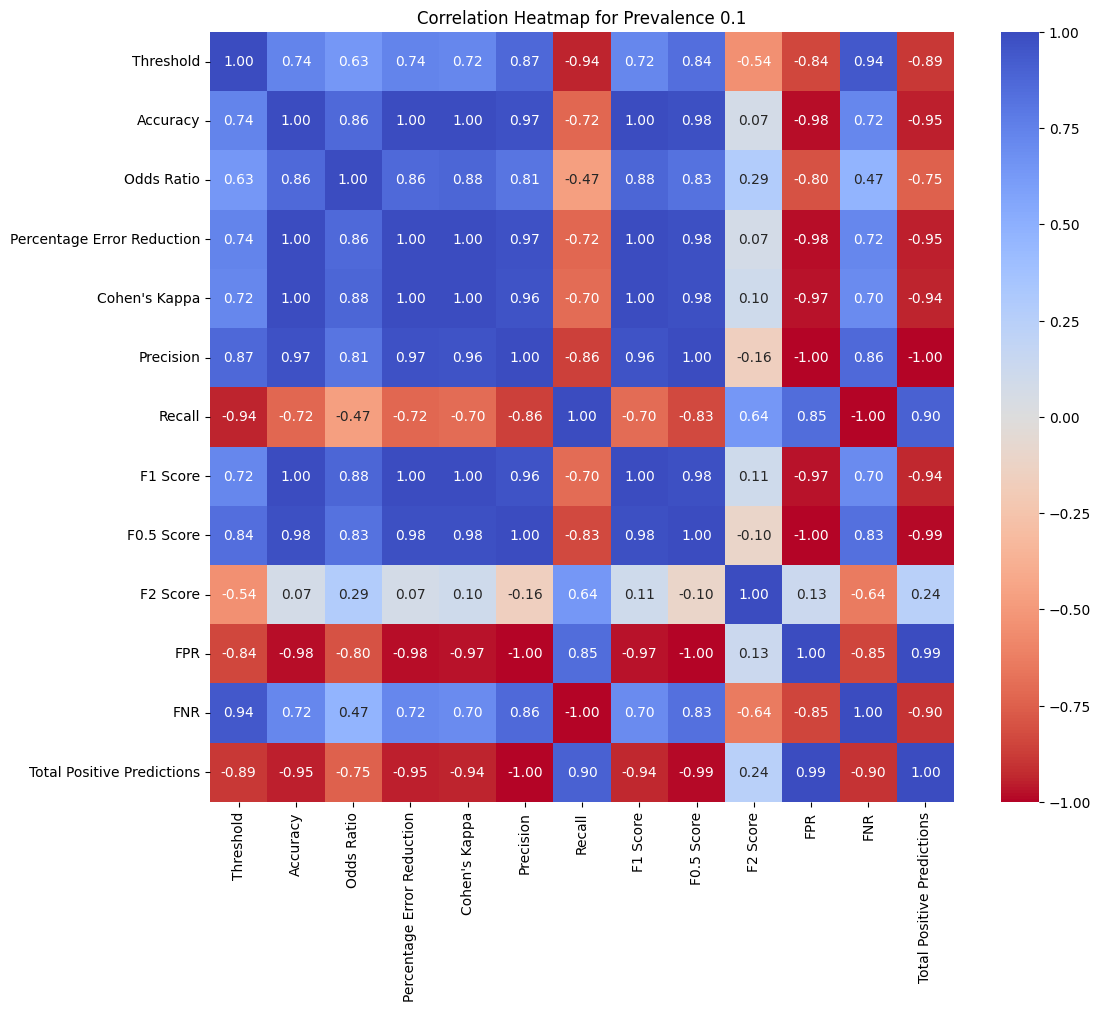

Index(['Threshold', 'Accuracy', 'Odds Ratio', 'Percentage Error Reduction',
       'Cohen's Kappa', 'Precision', 'Recall', 'F1 Score', 'F0.5 Score',
       'F2 Score', 'FPR', 'FNR', 'Total Positive Predictions'],
      dtype='object')


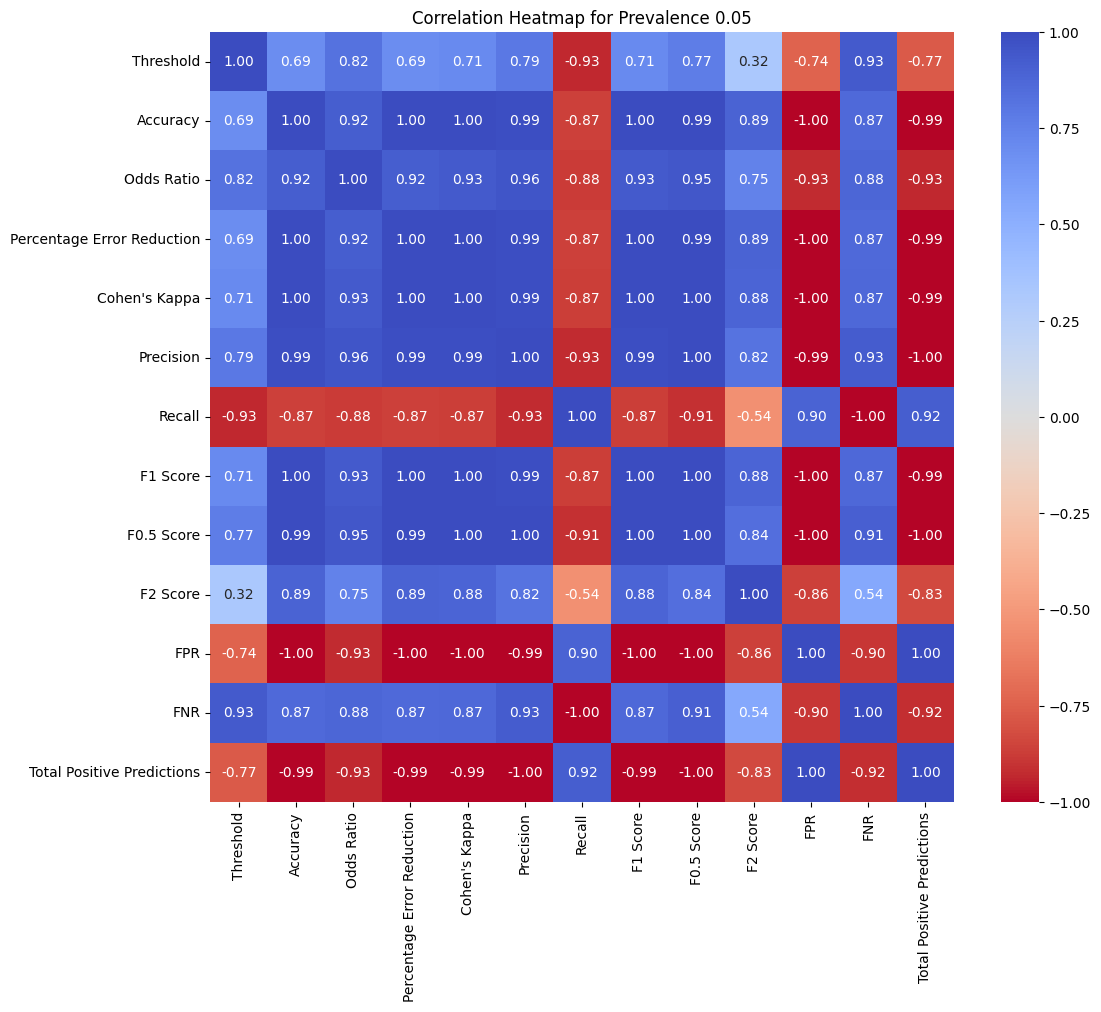

Index(['Threshold', 'Accuracy', 'Odds Ratio', 'Percentage Error Reduction',
       'Cohen's Kappa', 'Precision', 'Recall', 'F1 Score', 'F0.5 Score',
       'F2 Score', 'FPR', 'FNR', 'Total Positive Predictions'],
      dtype='object')


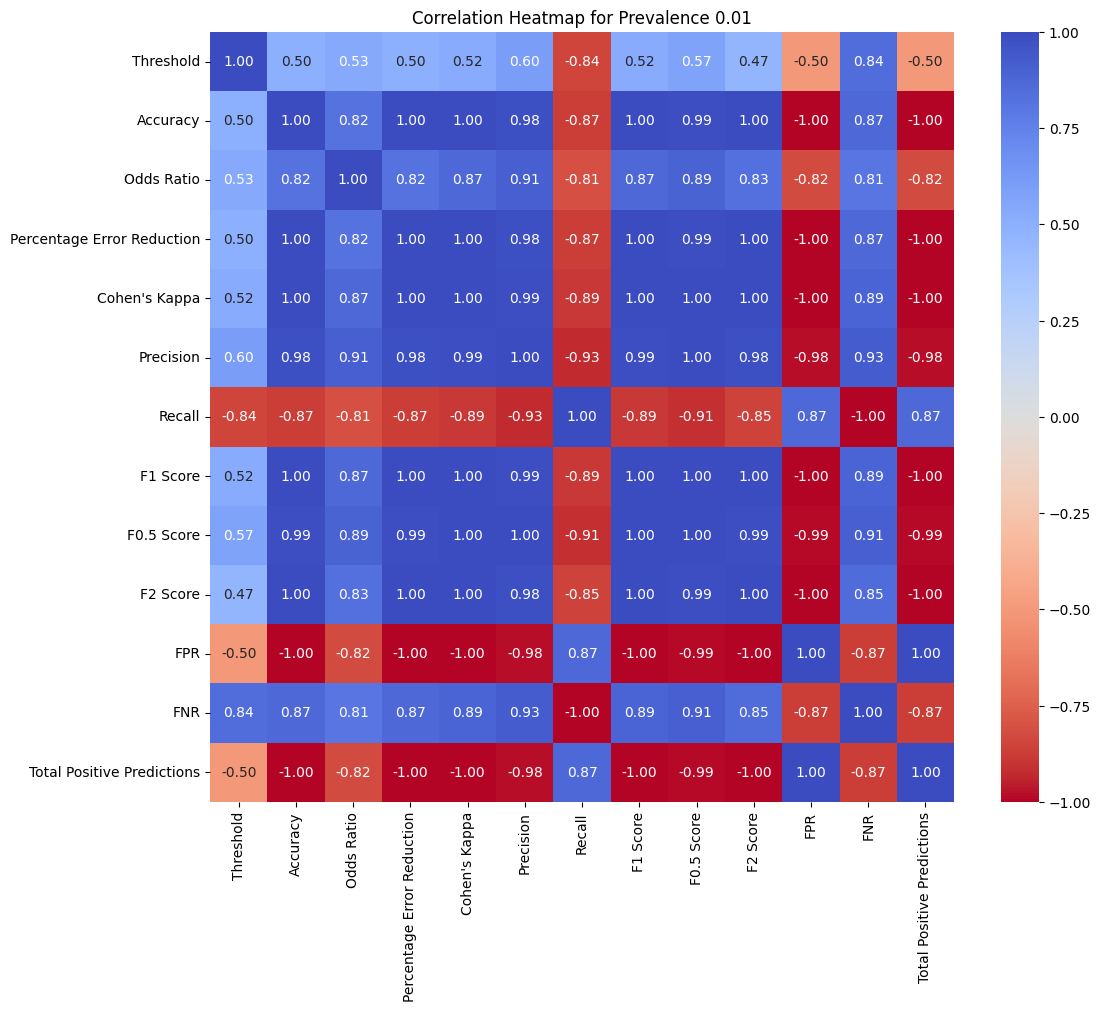

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_heatmaps(result):
    for prevalence, df_correlations in result.items():
        dfc = df_correlations.drop(columns=["Prevalence"])
        print(dfc.columns)
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            dfc,
            annot=True,
            cmap="coolwarm_r",
            fmt=".2f",
        )
        plt.title(f"Correlation Heatmap for Prevalence {prevalence}")
        plt.show()


# Example usage
plot_heatmaps(result)
